In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import numpy as np
import torch
from torch.optim import Adam, SGD
import matplotlib.pyplot as plt
from NCP.model import NCPOperator, NCPModule
from NCP.nn.layers import MLP
from NCP.nn.losses import CMELoss, DDPMLoss
from NCP.metrics import hellinger, kullback_leibler, wasserstein1
from NCP.utils import frnp, FastTensorDataLoader
import lightning as L
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks.model_checkpoint import ModelCheckpoint

from NCP.metrics import smooth_cdf

from NCP.cdf import compute_marginal

#import normflows as nf

# diffusion model imports:
from NCP.nn.diffusion_conditional import DDPM, ContextUnet
from NCP.nn.ddpm_module import DDPMModule

import itertools

from NCP.examples.tools.plot_utils import setup_plots
from NCP.examples.tools.data_gen import gen_bimodal, get_conditional_bimodal_cdf, get_conditional_bimodal_pdf
from NCP.examples.tools.lincde import lincde
setup_plots()

# TODO: add them to a utils folder
class CustomModelCheckpoint(ModelCheckpoint):
    def on_save_checkpoint(self, trainer, pl_module, checkpoint):
        X, Y = trainer.model.batch
        trainer.model.model._compute_data_statistics(X, Y)

def restore_buffers_shape(model, state_dict):
    model._sing_val = torch.zeros_like(state_dict['model._sing_val']).to('cpu')
    model._sing_vec_l = torch.zeros_like(state_dict['model._sing_vec_l']).to('cpu')
    model._sing_vec_r = torch.zeros_like(state_dict['model._sing_vec_r']).to('cpu')


np.random.seed(0)
torch.manual_seed(0)
Ntrain = 10000
Nval = 1000         # val dataset will be used to sample the marginal distribution of Y
Ntest = 1000

device = 'cuda' if torch.cuda.is_available() else 'cpu'

NEXP = 10

#MODELS = ['lincde', 'NN', 'ddpm]
MODELS = ['NN', 'ddpm']

Generating bimodal data as presented in LinCDE (Gao and Hastie). X are 20 dimensional, but only the first 3 dimensions impact Y. 
- the first dimension gives the mean, 
- the second the modality (bi or uni modal) 
- the third the asymetry.

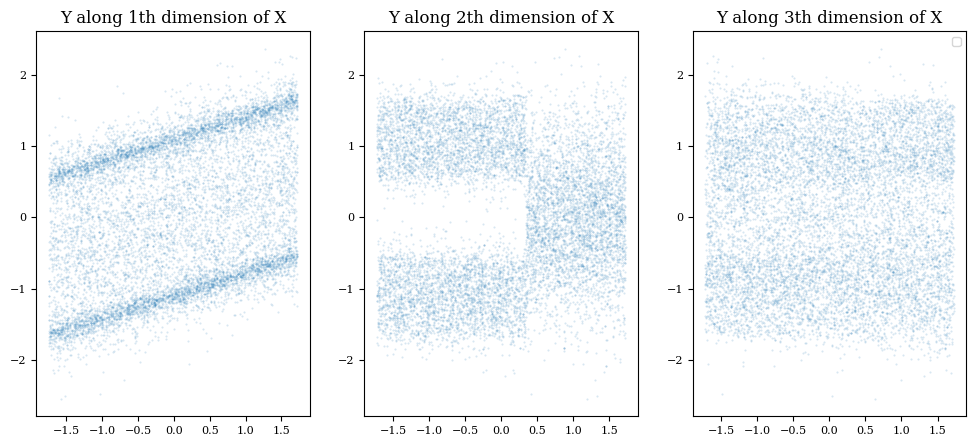

In [16]:
X_train, Y_train, X_val, Y_val, X_test, Y_test, xscaler, yscaler = gen_bimodal(0.5, 30, N_train=Ntrain, N_val=Nval, N_test=Ntest)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,5))
axes = ax.flatten()

for i, ax in enumerate(axes):
    ax.scatter(X_train[:,i], Y_train, alpha=0.2, s=0.2)
    ax.set_title(f'Y along {i+1}th dimension of X')
    if i == 0 :
        plt.legend(['train', 'val', 'test'])

plt.savefig('figures/dataset_lincde.pdf', format='pdf', bbox_inches='tight')
plt.show()

# 1. training NCP

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1129: 100%|██████████| 1/1 [00:00<00:00, 31.33it/s, v_num=220, val_loss=1.700, train_loss=-4.33]   


d:\Gregoire\anaconda3\envs\koopman\Lib\site-packages\lightning\pytorch\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


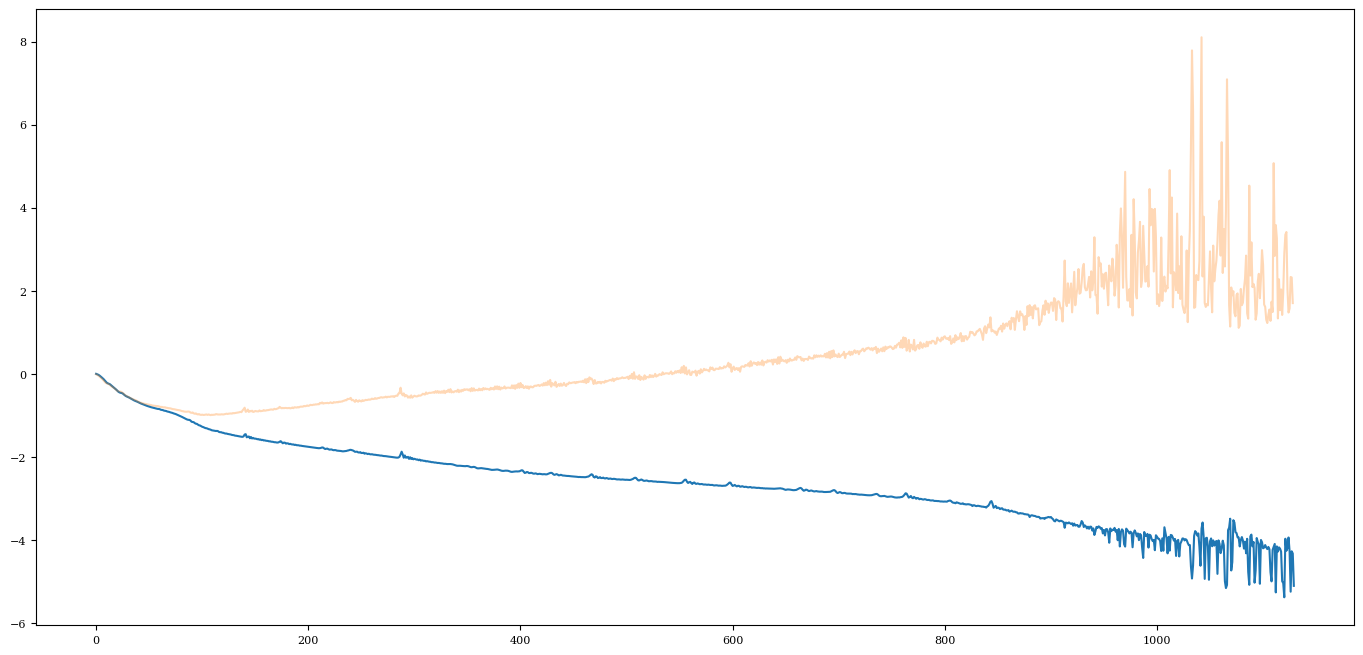

In [25]:
L.seed_everything(0)

lr = 1e-3
gamma = 0.
epochs = int(1e4)
output_shape = 1000

MLP_kwargs_U = {
    'input_shape': X_train.shape[-1],
    'output_shape': output_shape,
    'n_hidden': 3,
    'layer_size': [32, 64, 128],
    'dropout': 0.,
    'iterative_whitening': False,
    'activation': torch.nn.ReLU
}

MLP_kwargs_V = {
    'input_shape': Y_train.shape[-1],
    'output_shape': output_shape,
    'n_hidden': 3,
    'layer_size':[128, 128, 128],
    'dropout': 0,
    'iterative_whitening': False,
    'activation': torch.nn.ReLU
}

optimizer = Adam
optimizer_kwargs = {
    'lr': lr
    }

loss_fn = CMELoss
loss_kwargs = {
    'mode': 'split',
    'gamma': gamma
}

reg = NCPOperator(U_operator=MLP, V_operator=MLP, U_operator_kwargs=MLP_kwargs_U, V_operator_kwargs=MLP_kwargs_V)

X_train_torch = frnp(X_train)
Y_train_torch = frnp(Y_train)
X_val_torch = frnp(X_val)
Y_val_torch = frnp(Y_val)

NCP_module = NCPModule(
    reg,
    optimizer,
    optimizer_kwargs,
    CMELoss,
    loss_kwargs
)

#early_stop = EarlyStopping(monitor="val_loss", patience=100, mode="min")
checkpoint_callback = CustomModelCheckpoint(save_top_k=1, monitor="val_loss", mode="min")

train_dl = FastTensorDataLoader(X_train_torch, Y_train_torch, batch_size=len(X_train), shuffle=False)
val_dl = FastTensorDataLoader(X_val_torch, Y_val_torch, batch_size=len(X_train), shuffle=False)

trainer = L.Trainer(**{
    'accelerator': device,
    'max_epochs': epochs,
    'log_every_n_steps': 1,
    'enable_progress_bar': True,
    'devices': 1,
    'enable_checkpointing': True,
    'num_sanity_val_steps': 0,
    'enable_model_summary': False,
    }, callbacks=[checkpoint_callback]) 

trainer.fit(NCP_module, train_dataloaders=train_dl, val_dataloaders=val_dl)


# recover best model during training
best_model_dict = torch.load(checkpoint_callback.best_model_path)
restore_buffers_shape(reg, best_model_dict['state_dict'])
NCP_module.load_state_dict(best_model_dict['state_dict'])
best_model = NCP_module.model

plt.figure(figsize=(17, 8))
plt.plot(range(len(NCP_module.train_loss)), np.array(NCP_module.train_loss))
plt.plot(range(len(NCP_module.val_loss)), np.array(NCP_module.val_loss), alpha=0.3)
plt.show()

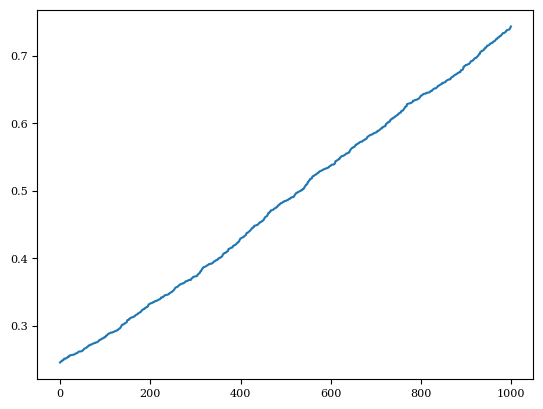

In [ ]:
plt.plot(np.sort(np.exp(-best_model.S.weights.detach().cpu().numpy()**2)))

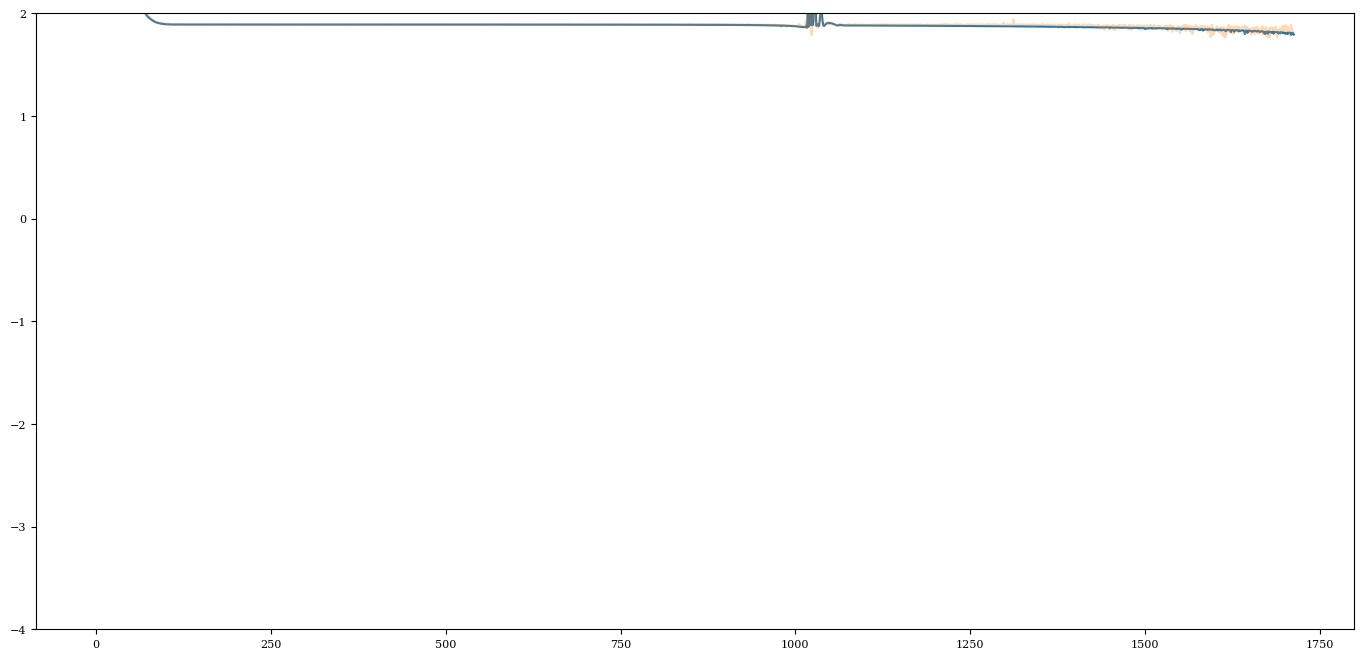

In [ ]:
plt.figure(figsize=(17, 8))
plt.plot(range(len(NCP_module.train_loss)), np.array(NCP_module.train_loss))
plt.plot(range(len(NCP_module.val_loss)), np.array(NCP_module.val_loss), alpha=0.3)
plt.ylim((-4, 2))
plt.show()

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

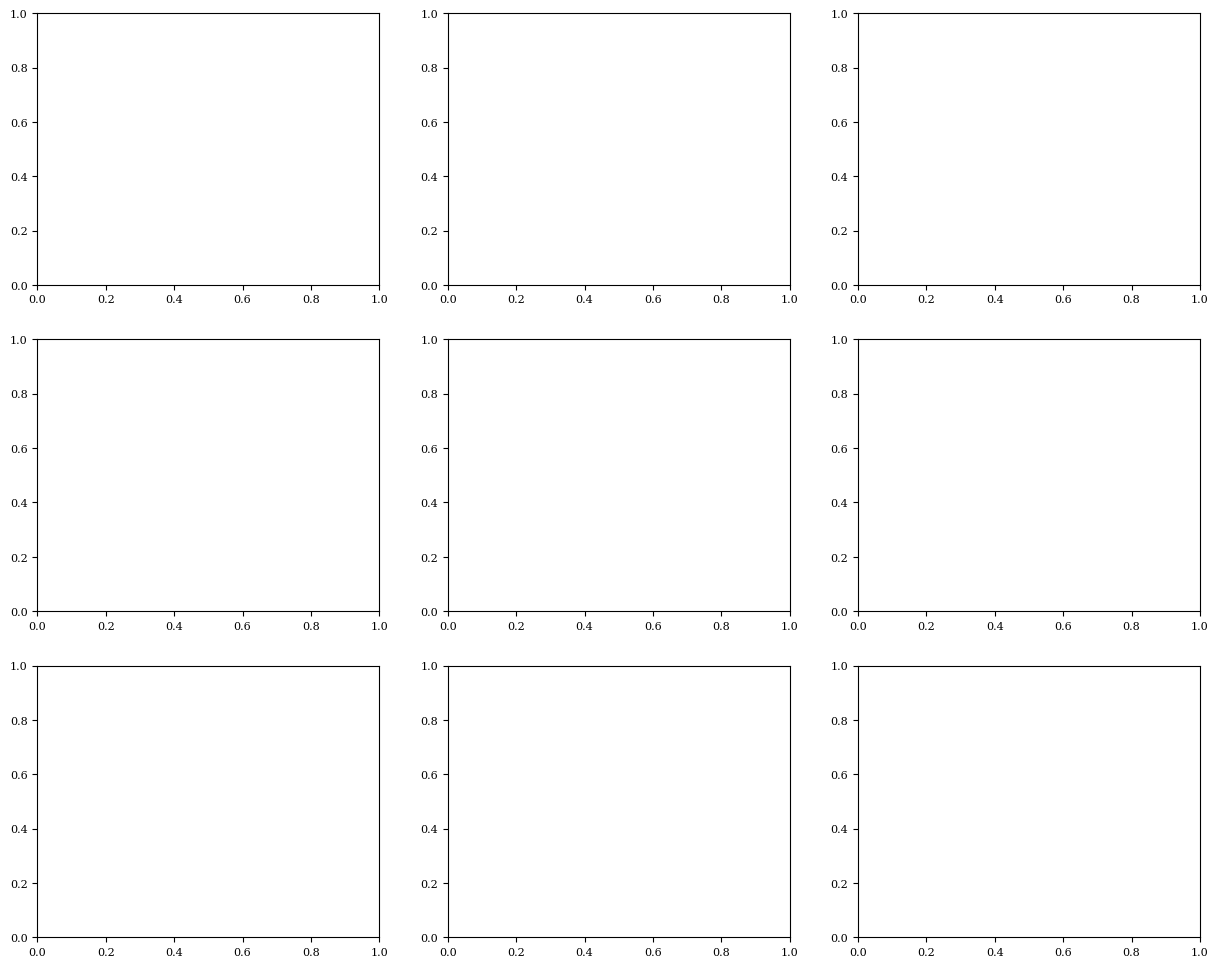

In [26]:
# todo: plot different cdfs, replicate plots from linCDE

x1 = [0] # mean
x3 = [-0.6, 0, 0.6] # asymetry
x2 = [-0.6, 0, 0.6] # modality

xs = itertools.product(x1, x2, x3)

fig, ax = plt.subplots(nrows=(len(x1)*len(x2)), ncols=len(x3), figsize=(15,12))
axes = ax.flatten()

for i, xi in enumerate(xs):
    x = list(xi) + [0]*17          # fill all other dimensions by 0
    x_scaled = torch.Tensor(xscaler.transform([x])).to(device)
    ys, cdf_pred_center = best_model.cdf(x_scaled, Y_val_torch.to(device), postprocess='centering')
    fys = yscaler.inverse_transform(ys.reshape([-1, 1])).flatten()

    true_cdf = get_conditional_bimodal_cdf(x, fys)
    axes[i].plot(fys, cdf_pred_center, marker='.',alpha=0.5, label='ours (centering only)')
    axes[i].plot(fys, true_cdf, label='Truth')
    
    if i==0:
        axes[i].legend()

    axes[i].set_title(f'x1={round(xi[0], 3)}, x2={round(xi[1], 3)}, x3={round(xi[2], 3)}')

plt.savefig('figures/vanilla_tanh_largesvd.pdf', format='pdf', bbox_inches='tight')
plt.show()

# 3. Diffusion models

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 9999: 100%|██████████| 1/1 [00:00<00:00, 33.42it/s, v_num=109, val_loss=0.467, train_loss=0.441] 

`Trainer.fit` stopped: `max_epochs=10000` reached.


Epoch 9999: 100%|██████████| 1/1 [00:00<00:00, 29.49it/s, v_num=109, val_loss=0.467, train_loss=0.441]


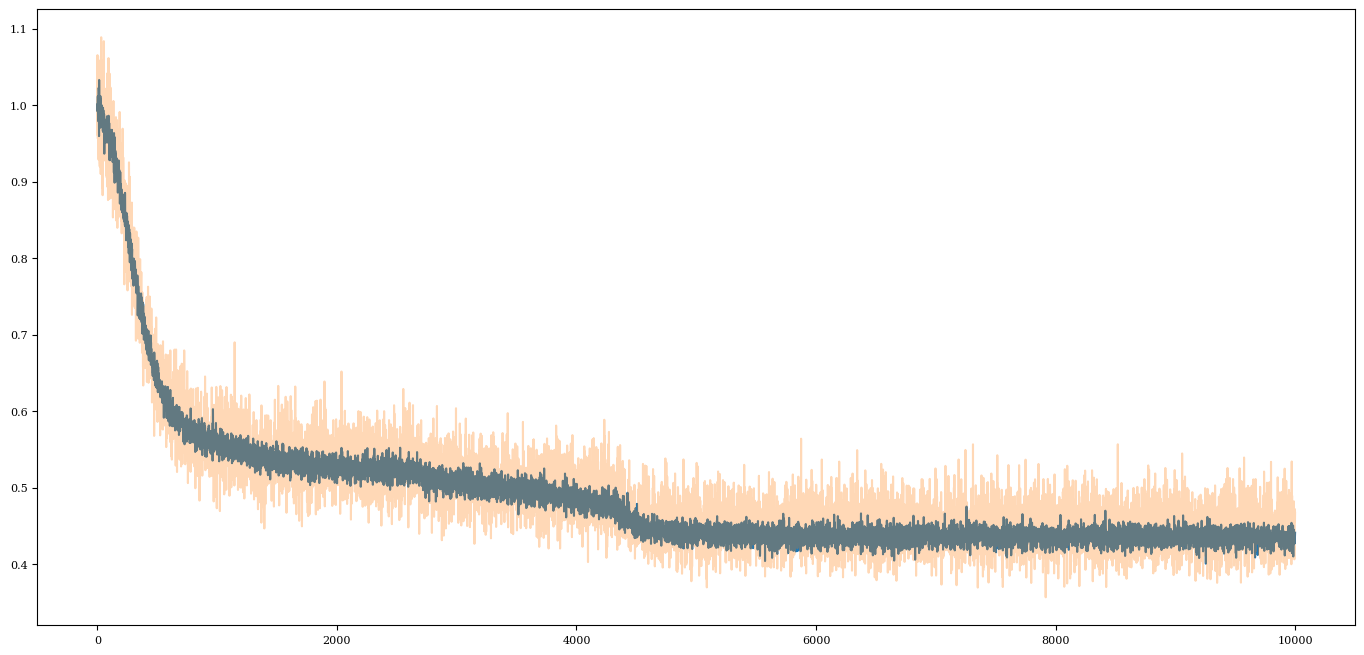

In [5]:
# based on https://github.com/TeaPearce/Conditional_Diffusion_MNIST/blob/main/script.py

#train_dl = FastTensorDataLoader(X_train_torch, Y_train_torch, batch_size=128, shuffle=False)
#val_dl = FastTensorDataLoader(X_val_torch, Y_val_torch, batch_size=128, shuffle=False)

L.seed_everything(0)

ddpm = DDPM(nn_model=ContextUnet(x_dim=X_train.shape[-1], y_dim=Y_train.shape[-1]), betas=(1e-4, 0.02), n_T=400, device=device, drop_prob=0.1)

ddpm_module = DDPMModule(ddpm,
    optimizer,
    optimizer_kwargs,
    DDPMLoss,
    loss_kwargs)

checkpoint_callback_vanilla = ModelCheckpoint(monitor="val_loss", mode="min")

trainer = L.Trainer(**{
    'accelerator': device,
    'max_epochs': int(1e4),
    'log_every_n_steps': 1,
    'enable_progress_bar': True,
    'devices': 1,
    'enable_checkpointing': True,
    'num_sanity_val_steps': 0,
    'enable_model_summary': False,
    }, callbacks=[checkpoint_callback_vanilla])

trainer.fit(ddpm_module, train_dataloaders=train_dl, val_dataloaders=val_dl)

checkpoint_callback_vanilla.best_model_path
best_model_dict = torch.load(checkpoint_callback_vanilla.best_model_path)
ddpm_module.load_state_dict(best_model_dict['state_dict'])

best_ddpm = ddpm_module.model

plt.figure(figsize=(17, 8))
plt.plot(range(len(ddpm_module.train_loss)), np.array(ddpm_module.train_loss))
plt.plot(range(len(ddpm_module.val_loss)), np.array(ddpm_module.val_loss), alpha=0.3)
plt.show()

In [6]:
from scipy.stats import ecdf

def cdf_from_sample(model:DDPM, x, ys, N=1000):
    samples, _ = model.sample(x, N, device='cpu')
    cdf = ecdf(samples.flatten())
    return cdf.cdf.evaluate(ys)

def pdf_from_sample(model:DDPM, x, ys, N=1000):
    samples, _ = model.sample(x, N, device='cpu')
    pdf = compute_marginal(bandwidth='scott').fit(np.array(samples))
    return pdf(ys)

# 4. Results

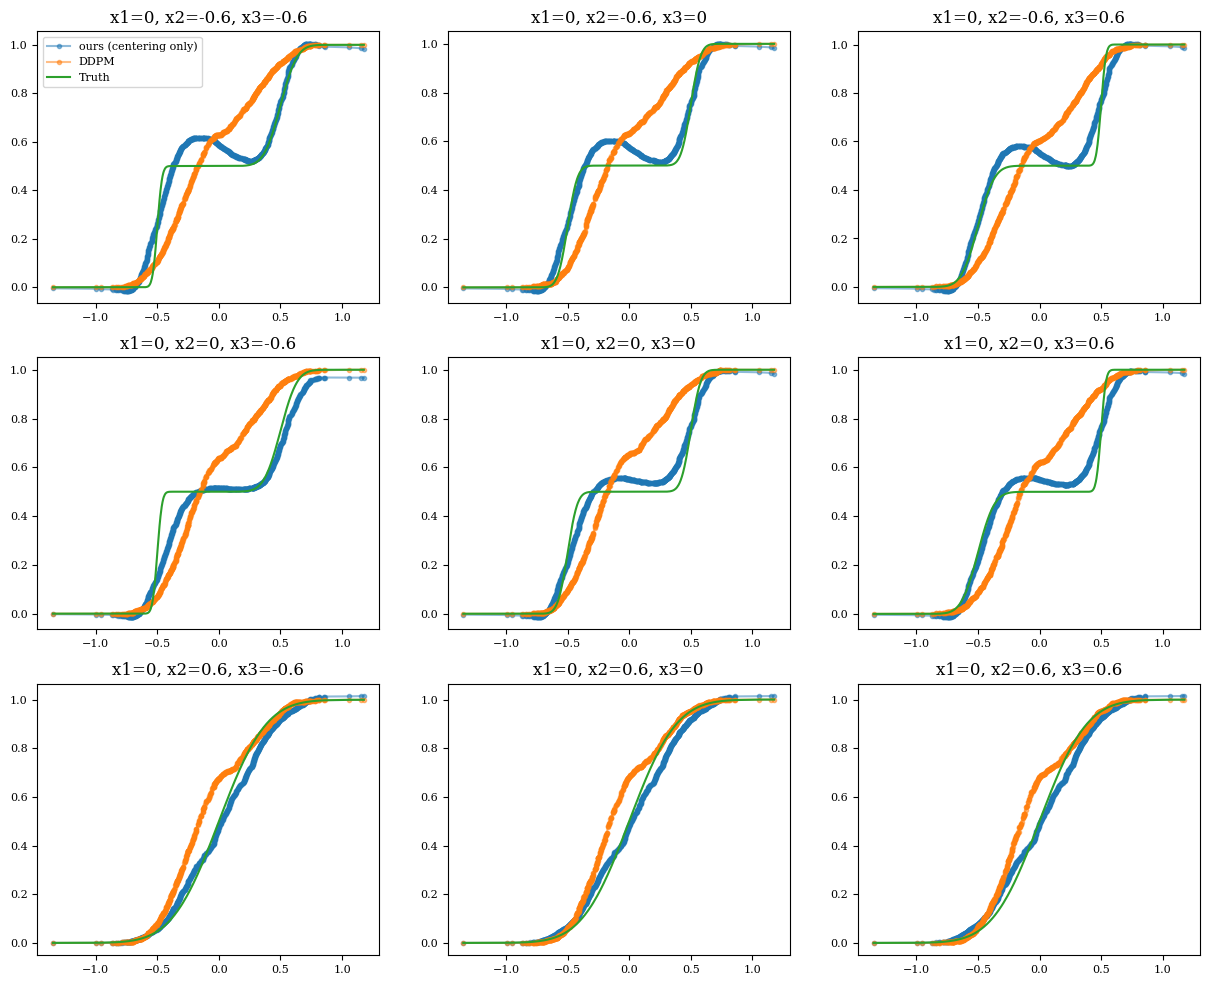

In [10]:
# todo: plot different cdfs, replicate plots from linCDE

x1 = [0] # mean
x3 = [-0.6, 0, 0.6] # asymetry
x2 = [-0.6, 0, 0.6] # modality

xs = itertools.product(x1, x2, x3)

fig, ax = plt.subplots(nrows=(len(x1)*len(x2)), ncols=len(x3), figsize=(15,12))
axes = ax.flatten()

for i, xi in enumerate(xs):
    x = list(xi) + [0]*17          # fill all other dimensions by 0
    x_scaled = torch.Tensor(xscaler.transform([x]))
    _, cdf_pred_center = best_model.cdf(x_scaled, Y_val_torch, postprocess='centering')
    fys = yscaler.inverse_transform(ys.reshape([-1, 1])).flatten()

    ddpm_cdf = cdf_from_sample(best_ddpm, x_scaled, ys)

    true_cdf = get_conditional_bimodal_cdf(x, fys)
    axes[i].plot(fys, cdf_pred_center, marker='.',alpha=0.5, label='ours (centering only)')
    axes[i].plot(fys, ddpm_cdf, marker='.',alpha=0.5, label='DDPM')
    axes[i].plot(fys, true_cdf, label='Truth')
    
    if i==0:
        axes[i].legend()

    axes[i].set_title(f'x1={round(xi[0], 3)}, x2={round(xi[1], 3)}, x3={round(xi[2], 3)}')

plt.savefig('figures/vanilla_cdf_1.pdf', format='pdf', bbox_inches='tight')
plt.show()

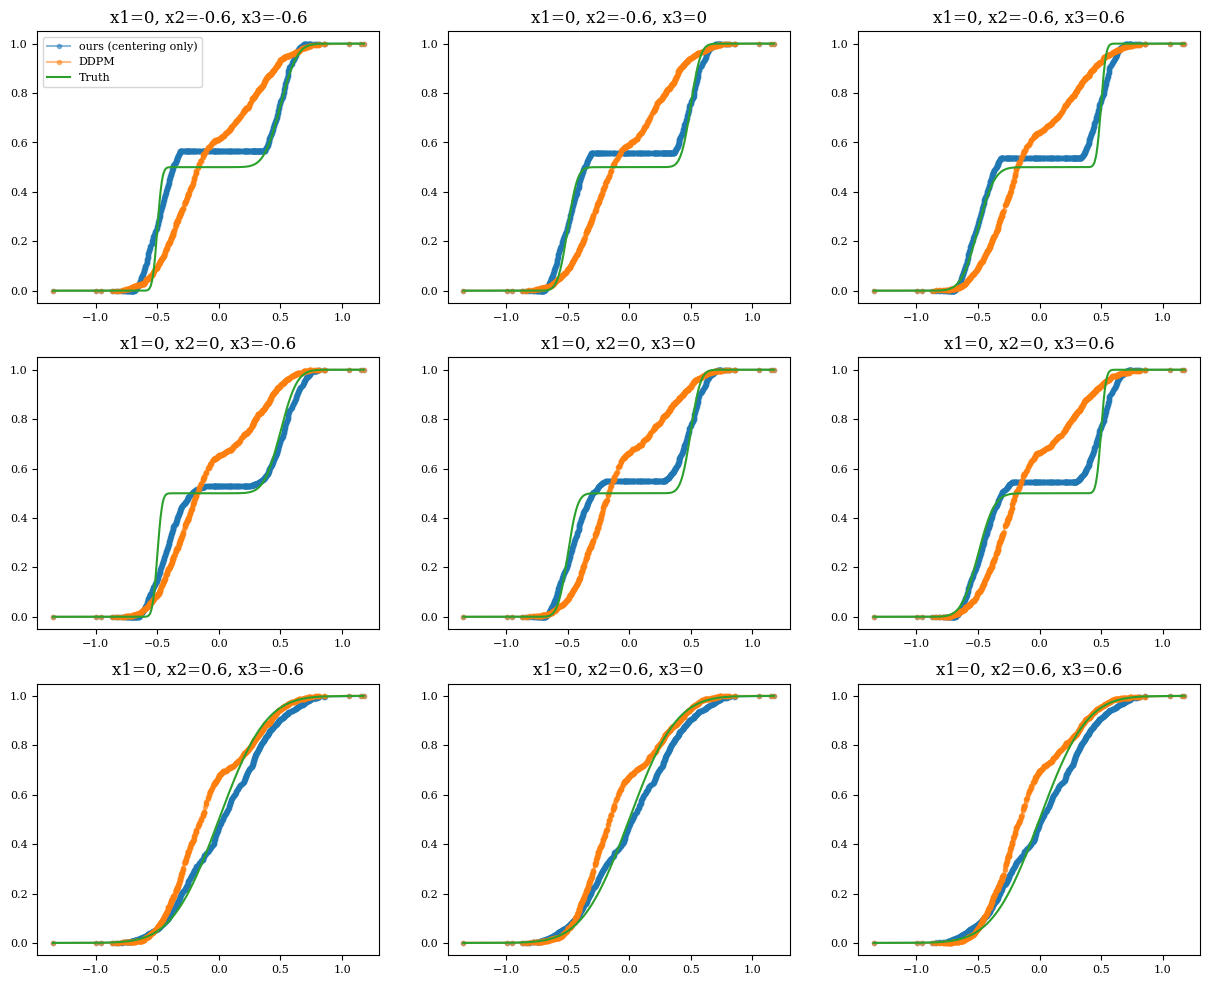

In [13]:
# todo: plot different cdfs, replicate plots from linCDE

x1 = [0] # mean
x3 = [-0.6, 0, 0.6] # asymetry
x2 = [-0.6, 0, 0.6] # modality

xs = itertools.product(x1, x2, x3)

fig, ax = plt.subplots(nrows=(len(x1)*len(x2)), ncols=len(x3), figsize=(15,12))
axes = ax.flatten()

for i, xi in enumerate(xs):
    x = list(xi) + [0]*17          # fill all other dimensions by 0
    x_scaled = torch.Tensor(xscaler.transform([x]))
    ys, cdf_pred = best_model.cdf(x_scaled, Y_val_torch, postprocess='whitening')
    _, cdf_pred_center = best_model.cdf(x_scaled, Y_val_torch, postprocess='centering')
    fys = yscaler.inverse_transform(ys.reshape([-1, 1])).flatten()

    cdf_pred = smooth_cdf(fys, cdf_pred)
    cdf_pred_center = smooth_cdf(fys, cdf_pred_center)

    ddpm_cdf = cdf_from_sample(best_ddpm, x_scaled, ys) #already smoothed by scipy

    true_cdf = get_conditional_bimodal_cdf(x, fys)

    axes[i].plot(fys, cdf_pred_center, marker='.',alpha=0.5, label='ours (centering only)')
    axes[i].plot(fys, ddpm_cdf, marker='.',alpha=0.5, label='DDPM')
    axes[i].plot(fys, true_cdf, label='Truth')
    
    if i==0:
        axes[i].legend()

    axes[i].set_title(f'x1={round(xi[0], 3)}, x2={round(xi[1], 3)}, x3={round(xi[2], 3)}')

plt.savefig('figures/smoothed_cdf_1.pdf', format='pdf', bbox_inches='tight')
plt.show()

Should we verify that the other dimensions are independent?

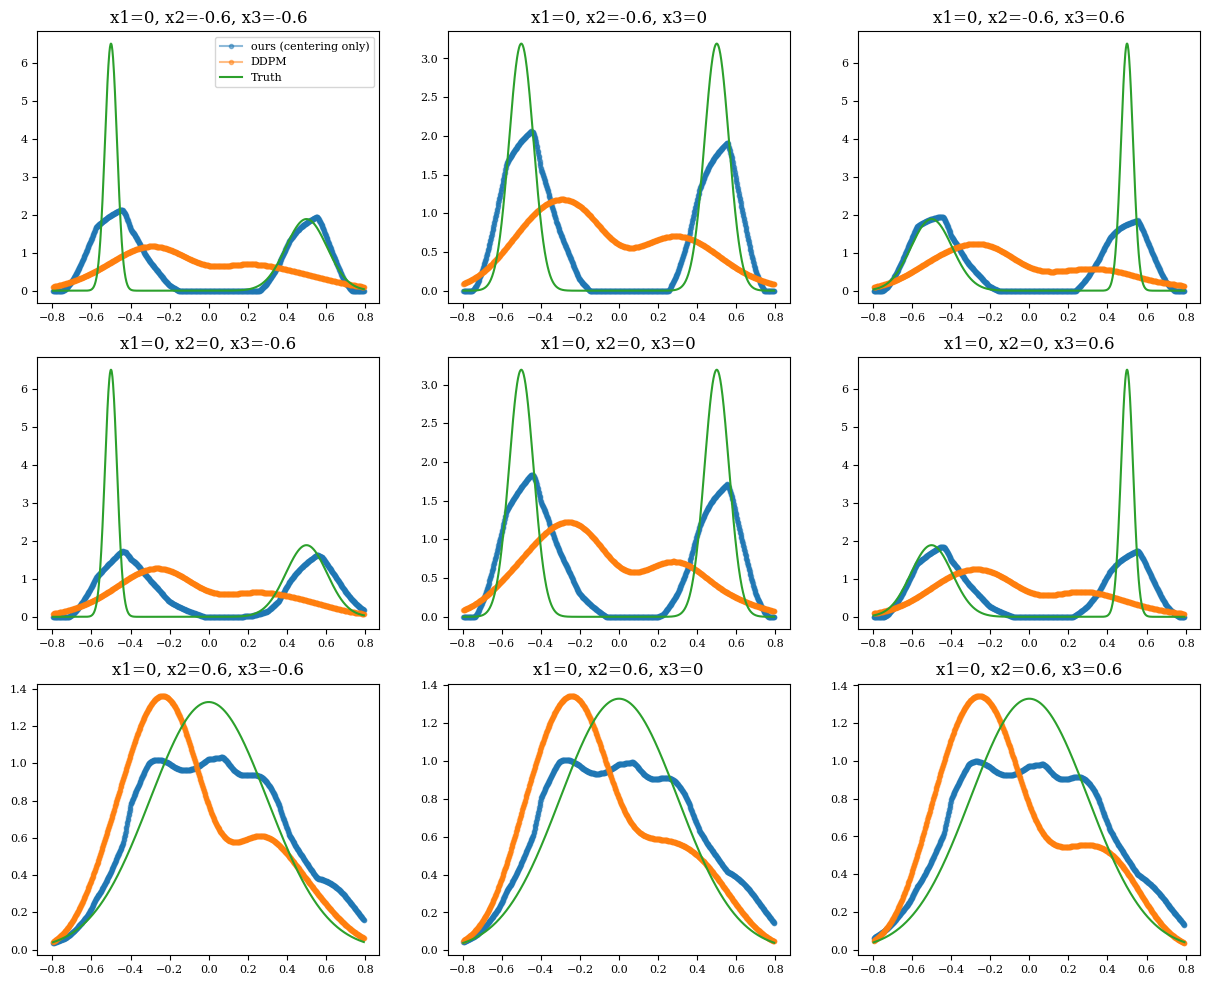

In [17]:
x1 = [0] # mean
x3 = [-0.6, 0, 0.6] # asymetry
x2 = [-0.6, 0, 0.6] # modality

xs = itertools.product(x1, x2, x3)

p1, p99 = np.percentile(Y_train, [1, 99])
y_discr, step = np.linspace(p1, p99, num=1000, retstep=True)
y_discr_torch = torch.Tensor(y_discr.reshape((-1, 1)))

fig, ax = plt.subplots(nrows=(len(x1)*len(x2)), ncols=len(x3), figsize=(15,12))
axes = ax.flatten()

k_pdf = compute_marginal(bandwidth='scott').fit(Y_train)
marginal = lambda x : torch.Tensor(np.exp(k_pdf.score_samples(x.reshape(-1, 1))))

for i, xi in enumerate(xs):
    x = list(xi) + [0]*17          # fill all other dimensions by 0
    x_scaled = xscaler.transform([x])
    x_scaled_torch = frnp(x_scaled)
    fys, pdf_pred_center = best_model.pdf(x_scaled_torch, y_discr_torch, p_y=marginal, postprocess='centering')
    fys = yscaler.inverse_transform(fys.reshape([-1, 1])).flatten()
    pdf_pred_center /= yscaler.scale_
    pdf_pred_center = np.maximum(pdf_pred_center, 0) # simple post processing to adress numerical errors

    ddpm_pdf = pdf_from_sample(best_ddpm, x_scaled_torch, ys)/ yscaler.scale_

    true_pdf = get_conditional_bimodal_pdf(x, fys)

    axes[i].plot(fys, pdf_pred_center, marker='.',alpha=0.5, label='ours (centering only)')
    axes[i].plot(fys, ddpm_pdf, marker='.',alpha=0.5, label='DDPM')
    axes[i].plot(fys, true_pdf, label='Truth')
    
    if 'lincde' in MODELS:
        y_lincde, lincde_pdf = cdf = lincde(X_train, Y_train, [x], y_discr)
        axes[i].plot(y_lincde, lincde_pdf, marker='-', lable='LinCDE')

    if i==0:
        axes[i].legend()

    axes[i].set_title(f'x1={round(xi[0], 3)}, x2={round(xi[1], 3)}, x3={round(xi[2], 3)}')

plt.savefig('figures/pdf_1.pdf', format='pdf', bbox_inches='tight')
plt.show()

computing metrics